In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
    data = pd.read_excel(filename)


Saving ACES_FINAL.xlsx to ACES_FINAL.xlsx


In [ ]:
data['pct_change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

Threshold = 1% Movement Distribution:
movement_1
 1    324
 0    160
-1    296
Name: count, dtype: int64

Threshold = 2% Movement Distribution:
movement_2
 1    254
 0    286
-1    240
Name: count, dtype: int64

Threshold = 3% Movement Distribution:
movement_3
 1    203
 0    394
-1    183
Name: count, dtype: int64



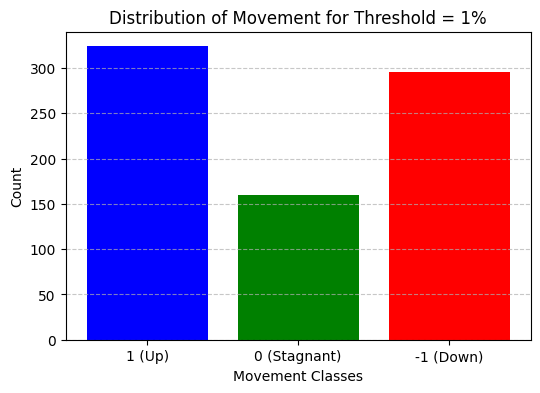

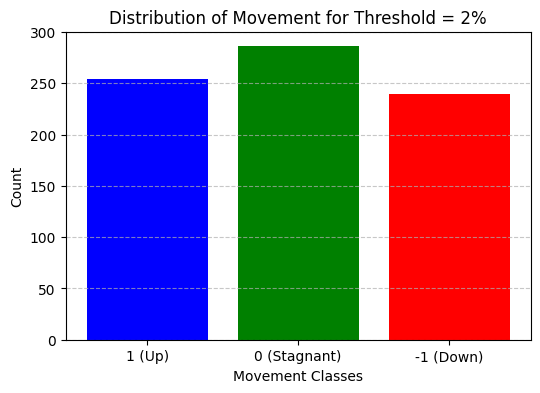

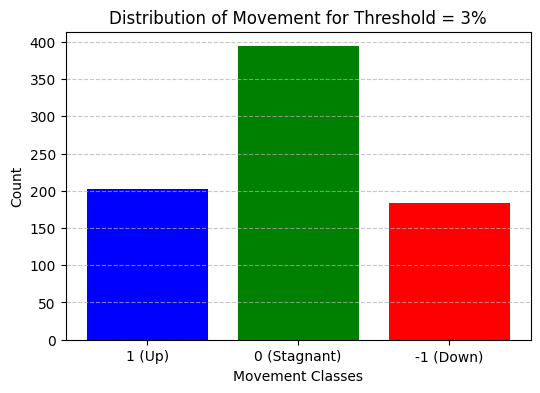

In [ ]:
thresholds = [1, 2, 3]
movement_distributions = {}

for threshold in thresholds:
    data[f'movement_{threshold}'] = data['pct_change'].apply(
        lambda x: 1 if x > threshold else (-1 if x < -threshold else 0)
    )
    movement_distributions[threshold] = data[f'movement_{threshold}'].value_counts().reindex([1, 0, -1], fill_value=0)

    print(f"Threshold = {threshold}% Movement Distribution:")
    print(movement_distributions[threshold])
    print()

colors = ['blue', 'green', 'red']
for threshold in thresholds:
    movement_counts = movement_distributions[threshold]
    x_labels = ['1 (Up)', '0 (Stagnant)', '-1 (Down)']

    plt.figure(figsize=(6, 4))
    plt.bar(x_labels, movement_counts.values, color=colors)
    plt.title(f'Distribution of Movement for Threshold = {threshold}%')
    plt.xlabel('Movement Classes')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

tampilkan data setelah di klasifikasi

In [ ]:
data

,Date,Close,EPS,ROA,ROE,Debt To Equity Ratio,P/B Value,P/E Ratio,pct_change,movement_1,movement_2,movement_3
1,2009-07-13,96.0,26.22,0.0480,0.0545,0.00,0.199435,3.661327,2.127660,1,1,0
2,2009-07-20,98.0,26.22,0.0480,0.0545,0.00,0.203590,3.737605,2.083333,1,1,0
3,2009-07-27,109.0,26.22,0.0480,0.0545,0.00,0.226442,4.157132,11.224490,1,1,1
4,2009-08-03,107.0,26.22,0.0480,0.0545,0.00,0.222287,4.080854,-1.834862,-1,0,0
5,2009-08-10,107.0,26.22,0.0480,0.0545,0.00,0.222287,4.080854,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
776,2024-05-20,800.0,9.38,0.0197,0.0271,0.11,2.313744,85.287846,-5.325444,-1,-1,-1
777,2024-05-27,820.0,9.38,0.0197,0.0271,0.11,2.371587,87.420043,2.500000,1,1,0
778,2024-06-03,835.0,9.38,0.0197,0.0271,0.11,2.414970,89.019190,1.829268,1,0,0
779,2024-06-10,840.0,9.38,0.0197,0.0271,0.11,2.429431,89.552239,0.598802,0,0,0


## Split Data

In [ ]:
best_threshold = 1

In [ ]:
X = data[['pct_change', 'EPS', 'ROA', 'ROE', 'Debt To Equity Ratio', 'P/B Value', 'P/E Ratio']].values
y = data[f'movement_{best_threshold}'].values

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Terapkan PCA
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Informasi variansi yang dijelaskan oleh PCA
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Explained Variance Ratio: {explained_variance}")
print(f"Cumulative Variance: {cumulative_variance}")

# Split data menjadi training dan testing
split_idx = int(0.8 * len(X))
X_train = X_pca[:split_idx]
X_test = X_pca[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# One-hot encoding untuk target
y_one_hot_train = to_categorical(y_train + 1, num_classes=3)
y_one_hot_test = to_categorical(y_test + 1, num_classes=3)

Explained Variance Ratio: [0.40801531 0.27365637 0.14212878 0.10515352]
Cumulative Variance: [0.40801531 0.68167168 0.82380046 0.92895398]


Training Data Distribution:
-1: 228
0: 133
1: 263

Testing Data Distribution:
-1: 68
0: 27
1: 61


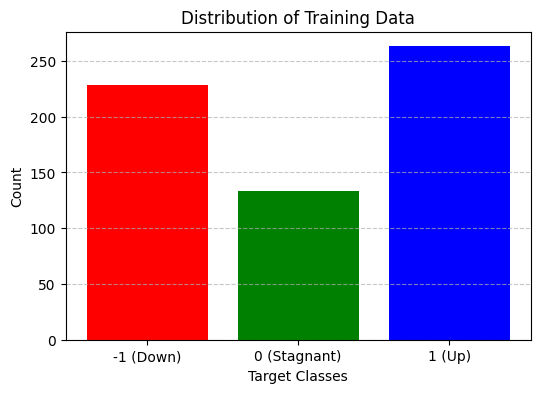

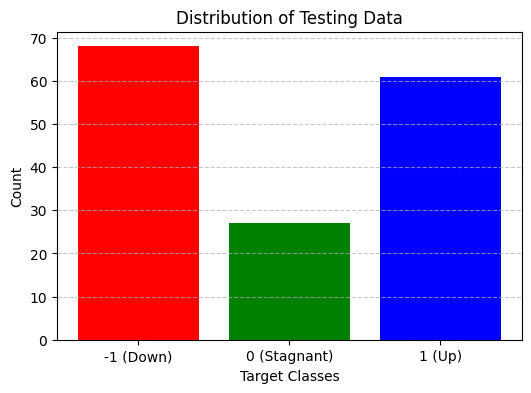

In [ ]:
train_distribution = np.unique(y_train, return_counts=True)
test_distribution = np.unique(y_test, return_counts=True)

train_dist_dict = dict(zip(train_distribution[0], train_distribution[1]))
test_dist_dict = dict(zip(test_distribution[0], test_distribution[1]))

classes = [-1, 0, 1]
train_counts = [train_dist_dict.get(cls, 0) for cls in classes]
test_counts = [test_dist_dict.get(cls, 0) for cls in classes]

print("Training Data Distribution:")
for cls, count in zip(classes, train_counts):
    print(f"{cls}: {count}")

print("\nTesting Data Distribution:")
for cls, count in zip(classes, test_counts):
    print(f"{cls}: {count}")

plt.figure(figsize=(6, 4))
plt.bar(['-1 (Down)', '0 (Stagnant)', '1 (Up)'], train_counts, color=['red', 'green', 'blue'])
plt.title('Distribution of Training Data')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['-1 (Down)', '0 (Stagnant)', '1 (Up)'], test_counts, color=['red', 'green', 'blue'])
plt.title('Distribution of Testing Data')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Normalisasi Data

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Bangun Model

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_dim=n_components, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Kompilasi Model

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Categorical Cross-Entropy adalah fungsi loss yang digunakan untuk mengukur seberapa baik model dalam mengklasifikasikan data ke dalam beberapa kelas yang lebih dari dua (multi-class classification).

## Latih Model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_one_hot_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3304 - loss: 1.7413 - val_accuracy: 0.3360 - val_loss: 1.6016
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3949 - loss: 1.5598 - val_accuracy: 0.5200 - val_loss: 1.4936
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.4763 - val_accuracy: 0.5920 - val_loss: 1.4090
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4961 - loss: 1.4123 - val_accuracy: 0.6480 - val_loss: 1.3377
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5851 - loss: 1.3339 - val_accuracy: 0.6960 - val_loss: 1.2719
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6576 - loss: 1.2174 - val_accuracy: 0.7280 - val_loss: 1.2036
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6548 - loss: 1.1626 - val_accuracy: 0.7280 - val_loss: 1.1393
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 1.0921 - val_accuracy: 0.7600 - 

## Evaluasi Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


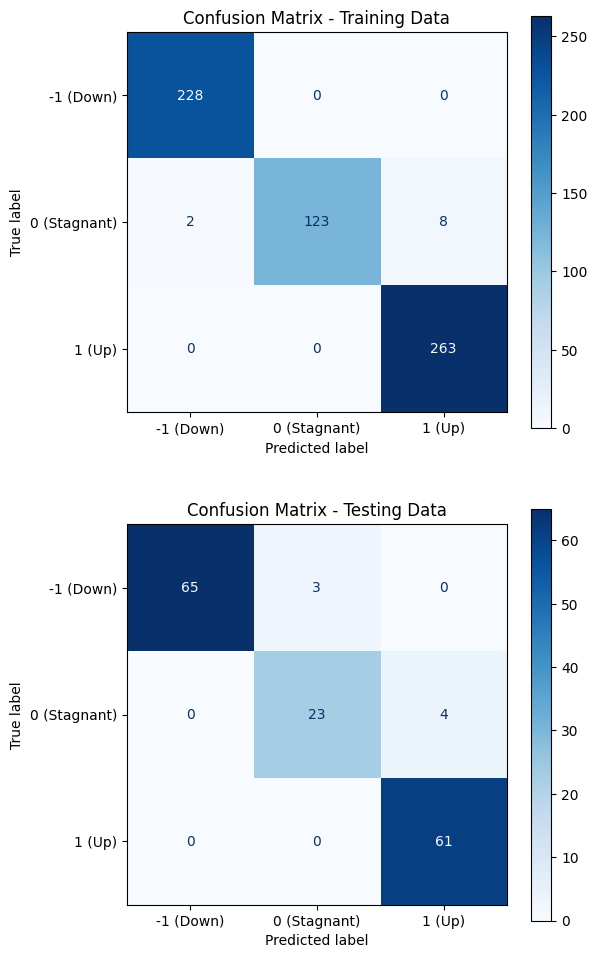

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1) - 1
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1) - 1
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1])

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=True)
axes[0].set_title("Confusion Matrix - Training Data")
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=True)
axes[1].set_title("Confusion Matrix - Testing Data")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

evaluation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Training': [train_accuracy, train_f1_score, train_precision, train_recall],
    'Testing': [test_accuracy, test_f1_score, test_precision, test_recall]
})

print(evaluation_results.to_string(index=False))

   Metric  Training  Testing
 Accuracy  0.983974 0.955128
 F1 Score  0.983764 0.954895
Precision  0.984381 0.955966
   Recall  0.983974 0.955128


THRESHOLD 2

In [ ]:
best_threshold = 2

X = data[['pct_change', 'EPS', 'ROA', 'ROE', 'Debt To Equity Ratio', 'P/B Value', 'P/E Ratio']].values
y = data[f'movement_{best_threshold}'].values

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Terapkan PCA
n_components = 4  # Jumlah komponen yang ingin dipertahankan
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Informasi variansi yang dijelaskan oleh PCA
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Split data menjadi training dan testing
split_idx = int(0.8 * len(X))
X_train = X_pca[:split_idx]
X_test = X_pca[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# One-hot encoding untuk target
y_one_hot_train = to_categorical(y_train + 1, num_classes=3)
y_one_hot_test = to_categorical(y_test + 1, num_classes=3)

model = Sequential([
    Dense(64, activation='relu', input_dim=n_components, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_one_hot_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Explained Variance Ratio: [0.40801531 0.27365637 0.14212878 0.10515352]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3821 - loss: 1.7161 - val_accuracy: 0.6320 - val_loss: 1.4921
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4404 - loss: 1.5505 - val_accuracy: 0.7280 - val_loss: 1.4056
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4979 - loss: 1.4218 - val_accuracy: 0.8000 - val_loss: 1.3289
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5079 - loss: 1.3773 - val_accuracy: 0.7760 - val_loss: 1.2506
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5620 - loss: 1.2860 - val_accuracy: 0.7360 - val_loss: 1.1752
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5556 - loss: 1.2619 - val_accuracy: 0.7280 - val_loss: 1.1030
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6166 - loss: 1.1676 - val_accuracy: 0.7280 - val_loss: 1.0370
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6747 - loss: 1.0927 - val_accuracy: 0.7440 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


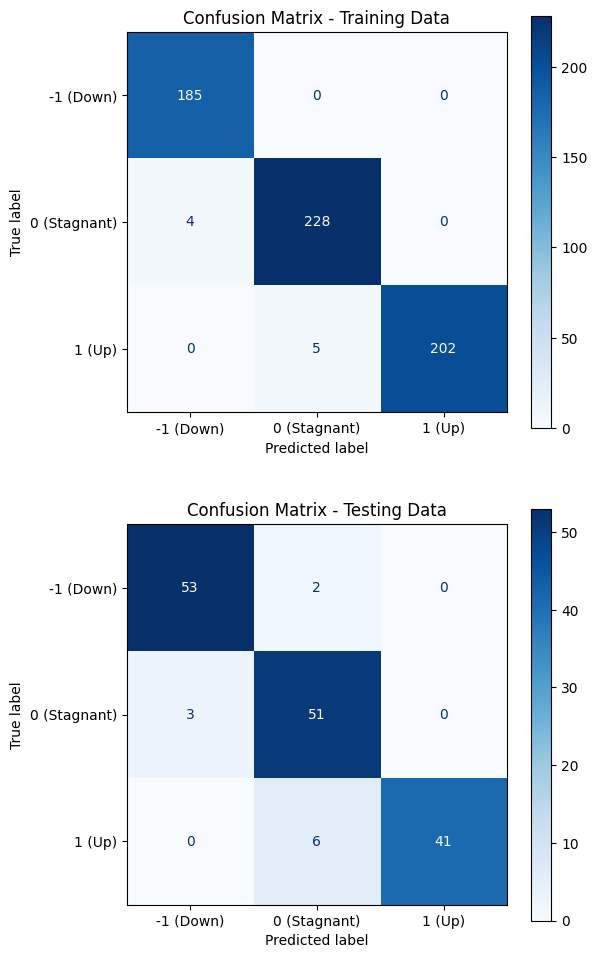

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1) - 1
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1) - 1
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1])

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=True)
axes[0].set_title("Confusion Matrix - Training Data")
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=True)
axes[1].set_title("Confusion Matrix - Testing Data")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

evaluation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Training': [train_accuracy, train_f1_score, train_precision, train_recall],
    'Testing': [test_accuracy, test_f1_score, test_precision, test_recall]
})

print(evaluation_results.to_string(index=False))

   Metric  Training  Testing
 Accuracy  0.985577 0.929487
 F1 Score  0.985578 0.929880
Precision  0.985747 0.934177
   Recall  0.985577 0.929487


THRESHOLD 3

In [ ]:
best_threshold = 3

X = data[['pct_change', 'EPS', 'ROA', 'ROE','Debt To Equity Ratio', 'P/B Value', 'P/E Ratio']].values
y = data[f'movement_{best_threshold}'].values

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Terapkan PCA
n_components = 4  # Jumlah komponen yang ingin dipertahankan
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Informasi variansi yang dijelaskan oleh PCA
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Split data menjadi training dan testing
split_idx = int(0.8 * len(X))
X_train = X_pca[:split_idx]
X_test = X_pca[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# One-hot encoding untuk target
y_one_hot_train = to_categorical(y_train + 1, num_classes=3)
y_one_hot_test = to_categorical(y_test + 1, num_classes=3)

model = Sequential([
    Dense(64, activation='relu', input_dim=n_components, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_one_hot_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Explained Variance Ratio: [0.40801531 0.27365637 0.14212878 0.10515352]
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2497 - loss: 1.7658 - val_accuracy: 0.5120 - val_loss: 1.5344
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3782 - loss: 1.5703 - val_accuracy: 0.5920 - val_loss: 1.4383
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4752 - loss: 1.4943 - val_accuracy: 0.6400 - val_loss: 1.3620
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5276 - loss: 1.4357 - val_accuracy: 0.6640 - val_loss: 1.2900
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5369 - loss: 1.3480 - val_accuracy: 0.7600 - val_loss: 1.2232
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6190 - loss: 1.2650 - val_accuracy: 0.7920 - val_loss: 1.1578
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6558 - loss: 1.2315 - val_accuracy: 0.8240 - val_loss: 1.0915
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6964 - loss: 1.1355 - val_accuracy: 0.8400 - val_loss: 1.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


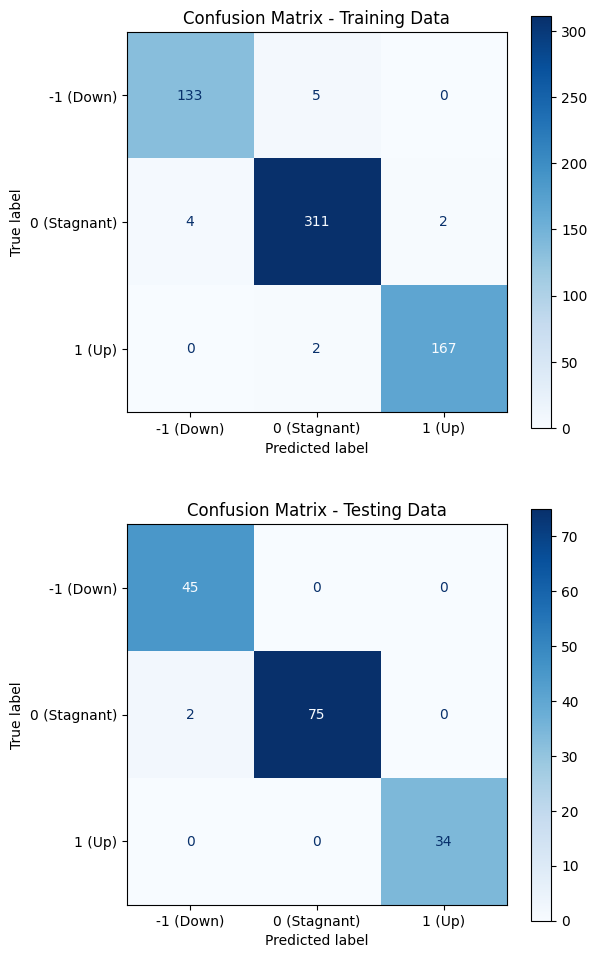

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1) - 1
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1) - 1
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=[-1, 0, 1])

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=True)
axes[0].set_title("Confusion Matrix - Training Data")
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['-1 (Down)', '0 (Stagnant)', '1 (Up)'])
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=True)
axes[1].set_title("Confusion Matrix - Testing Data")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

evaluation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Training': [train_accuracy, train_f1_score, train_precision, train_recall],
    'Testing': [test_accuracy, test_f1_score, test_precision, test_recall]
})

print(evaluation_results.to_string(index=False))

   Metric  Training  Testing
 Accuracy  0.979167 0.987179
 F1 Score  0.979157 0.987234
Precision  0.979155 0.987725
   Recall  0.979167 0.987179
